In [1]:
import glob
import numpy as np
from numpy import random as rng
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm
from scipy import stats
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
trainCV = pd.read_csv("../trainCV.csv")
testCV = pd.read_csv("../testCV.csv")
train = pd.concat([trainCV,testCV],ignore_index=1)
test = pd.read_csv("../test.csv")

In [46]:
class XYPair():
    def __init__(self,idx,w=640,h=480,threshMask=120,blur=15,training=1):
        if training == 1:
            obs = train.iloc[idx]
            self.xPath = "../train/"+obs["classname"]+"/"+obs["img"]
            maskPath = "../train/"+obs["classname"]+"/"+obs["img"].replace(".jpg","_mask.jpg")
        else:
            obs = test.iloc[idx]
            self.xPath = "../"+obs["img"]
            maskPath = "../"+obs["img"].replace(".jpg","_mask.jpg")
            
        self.x = cv2.imread(self.xPath)
        mask = cv2.imread(maskPath,0)
        mask = cv2.resize(mask,(w,h))
        mask = cv2.GaussianBlur(mask,(blur,blur),1)

        _,self.mask = cv2.threshold(mask,threshMask,255,cv2.THRESH_BINARY)
        #self.mask = stats.threshold(mask, threshmin=threshMask, threshmax=255, newval=0).astype(bool)
        
        # Generate
        contours,im2 = cv2.findContours(self.mask.astype(np.uint8), 1, 2)
        self.xFeatures = self.x.copy()
        self.maskSquare = self.mask.copy()
        
        for cnt in contours:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(self.maskSquare,(x,y),(x+w,y+h),(255,255,255),-1)
            cv2.rectangle(self.xFeatures,(x,y),(x+w,y+h),(0,255,0),2)
            
        #self.maskSquare[:,np.where(self.maskSquare==255)[1][0]:] = 255
        maskTiled = np.tile(np.expand_dims(self.maskSquare.astype(bool),3),(1,1,3))
        self.xCropped = self.x.copy()
        self.xCropped[maskTiled==False]=0
        self.xCropped = cv2.resize(self.xCropped,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)

    def display(self,w=12,h=9):
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = w
        fig_size[1] = h
        plt.subplot(151)
        plt.imshow(self.x)
        plt.subplot(152)
        plt.imshow(self.mask,cmap=cm.gray)
        plt.subplot(153)
        plt.imshow(self.maskSquare,cmap=cm.gray)
        plt.subplot(154)
        plt.imshow(self.xFeatures)
        plt.subplot(155)
        plt.imshow(self.xCropped)
        plt.title(self.xPath)
        plt.show()
        
    def save(self):
        cv2.imwrite(self.xPath.replace(".jpg","_x.jpg"),self.xCropped)


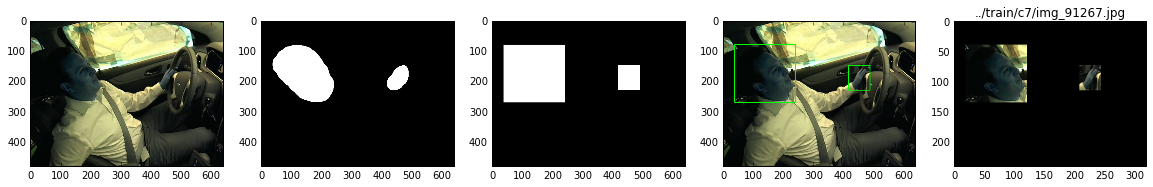

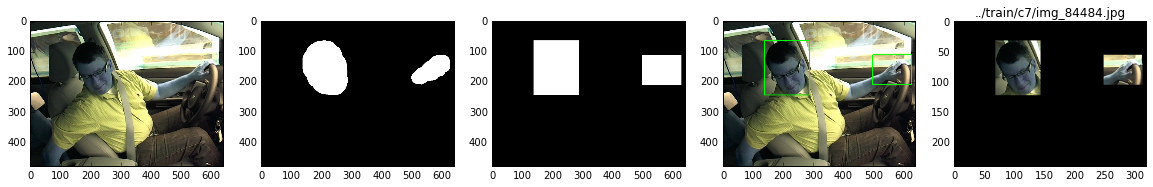

In [47]:
noMasks = []
for idx in rng.choice(train.loc[train["classname"]=="c7"].index,2):
    #try:
    xyPair = XYPair(idx,threshMask=50,blur=31,training=1)
    xyPair.display(20,15)
    #xyPair.save()
    if idx % 1000 == 0:
        print("%d out of %d" % (idx,train.shape[0]))
    #except:
        #print(idx)
        #print("not there")
        #noMasks.append(i)
        